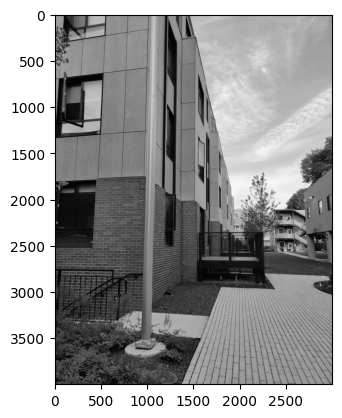

In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load images.
folder = "C:/Users/ROHIT/Downloads/HW2/imgs"
building_files = [os.path.join(folder, filename) for filename in os.listdir(folder) if filename.endswith('.jpg')]

# for filename in os.listdir(folder):
#     print(filename)
# Display images to be stitched.
for file in building_files:
    image = cv2.imread(file)
    # cv2.imshow('Building Images', image)
    # cv2.waitKey(1000)

# Read the first image from the image set.
J = cv2.imread(building_files[0])
I = cv2.GaussianBlur(J, (0, 0), 1)
gray_image = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
# gray_image = cv2.cvtColor(gray_image, cv2.COLOR_RGB2GRAY)


# Initialize features for I(1)
orb = cv2.ORB_create(nlevels=1)
# points = orb.detect(gray_image, None)
# print(points)
# kp1, features = orb.compute(gray_image, points)

points1, features1 = orb.detectAndCompute(gray_image, None)

# Display detected features
for point in points1:
    x, y = map(int, point.pt)
    cv2.circle(I, (x, y), 10, (0, 0, 255), -1)


plt.figure()
plt.imshow(gray_image,  cmap="gray", vmin=0, vmax=255)
# cv2.imshow('Detected Features', I)
# cv2.waitKey(1000)

# Initialize all the transformations to the identity matrix.
num_images = len(building_files)
tforms = [np.eye(3) for _ in range(num_images)]

# Initialize variable to hold image sizes.
image_sizes = []



In [2]:
img_normalized = cv2.normalize(gray_image, None, -1.0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
cv2.imshow('nor',cv2.resize(img_normalized,(0, 0), fx = 0.2, fy = 0.2))
cv2.waitKey(5000)
cv2.destroyAllWindows()

In [3]:
J = cv2.imread(building_files[1])
I = cv2.GaussianBlur(J, (0, 0), 1)
gray_image2 = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
gray_image2 = cv2.cvtColor(gray_image2, cv2.COLOR_RGB2GRAY)
points2, features2 = orb.detectAndCompute(gray_image2, None)

In [4]:
def blendImgs(Img1, Img2):
    fg, bg = Img1.copy(), Img2.copy()
    fg_h,fg_w = fg.shape
    bg_h,bg_w = bg.shape
    dy = bg_h - fg_h
    dx = bg_w - fg_w
    alpha = 0.75
    fg = cv2.copyMakeBorder(fg, top=0, left=0, bottom=dy, right=dx, borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])   
    fg_mask = cv2.inRange(fg, 0, 0)
    bg_mask = cv2.inRange(bg, 0, 0)
    blend = cv2.addWeighted(fg, alpha, bg, 1-alpha, 0, bg.shape)
    BGnotFG = (bg_mask != 255) & (fg_mask == 255)
    FGnotBG = (fg_mask != 255) & (bg_mask == 255)
    blend[BGnotFG] = bg[BGnotFG]
    blend[FGnotBG] = fg[FGnotBG]
    return blend

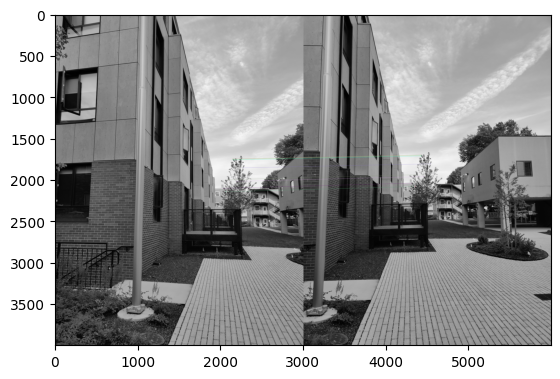

(<matplotlib.image.AxesImage at 0x1ef25f33f10>, None)

In [5]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(features1,features2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv2.drawMatches(gray_image,points1,gray_image2,points2,matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

In [6]:
matched_points = np.array([points2[m.trainIdx].pt for m in matches])
matched_points_prev = np.array([points1[m.queryIdx].pt for m in matches])
print(len(matched_points),len(matched_points_prev))
H, _ = cv2.findHomography(matched_points, matched_points_prev, cv2.RANSAC, 5.0)
tforms[1] = np.dot(H, tforms[1 - 1])
size = [4000,3000]
corners = np.array([[0, 0], [size[1], 0], [size[1], size[0]], [0, size[0]]], dtype=np.float32)
# print(tforms)

transformed_corners = cv2.perspectiveTransform(corners.reshape(1, -1, 2), tforms[1])


276 276


In [7]:
height, width = gray_image.shape
panorama = np.zeros((height, width), dtype=np.uint8)
mask = np.zeros((height, width), dtype=np.uint8)

I = gray_image2

    # Transform I into the panorama.
warped_image = cv2.warpPerspective(I, tforms[0], (width, height))

    # Generate a binary mask.
mask.fill(0)
mask = cv2.fillConvexPoly(mask, np.array(transformed_corners, dtype=np.int32), 1)

print(panorama.shape, warped_image.shape)
#     # Overlay the warped image onto the panorama.

# panorama = cv2.add(panorama, warped_image, dst=panorama, mask=mask)

panorama = blendImgs(gray_image, warped_image)
cv2.imshow('Panorama', cv2.resize(panorama,(0, 0), fx = 0.2, fy = 0.2))
cv2.waitKey(0)
cv2.destroyAllWindows()

(4000, 3000) (4000, 3000)


In [8]:
# Iterate over remaining image pairs
for n in range(1, num_images):
    # Store points and features for I(n-1).
    points_previous = points1
    features_previous = features1

    # Read I(n).
    J = cv2.imread(building_files[n])
    I = cv2.GaussianBlur(J, (0, 0), 1)
    gray_image = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

    # Save image size.
    image_sizes.append(gray_image.shape)

    # Detect ORB features for I(n).
    points = orb.detect(gray_image, None)
    _, features = orb.compute(gray_image, points)

    # Find correspondences between I(n) and I(n-1).
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(features, features_previous)

    # Filter matches based on a threshold.
    matches = [m for m in matches if m.distance < 13]

    # Get matched points
    matched_points = np.array([points[m.trainIdx].pt for m in matches])
    matched_points_prev = np.array([points_previous[m.queryIdx].pt for m in matches])
    print(len(matched_points),len(matched_points_prev))
    # Estimate the transformation between I(n) and I(n-1).
    # _, H = cv2.findHomography(matched_points.reshape(-1, 1, 2), matched_points_prev.reshape(-1, 1, 2), cv2.RANSAC, 5.0)
    H, _ = cv2.findHomography(matched_points, matched_points_prev, cv2.RANSAC, 5.0)
    print(H,n)
    tforms[n] = np.dot(H, tforms[n - 1])



3 3


error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'


In [16]:
# Compute the output limits for each transform.
x_lims, y_lims = [], []
for tform, size in zip(tforms, image_sizes):
    corners = np.array([[0, 0], [size[1], 0], [size[1], size[0]], [0, size[0]]], dtype=np.float32)
    transformed_corners = cv2.perspectiveTransform(corners.reshape(1, -1, 2), tform)
    x, y = transformed_corners[:, :, 0], transformed_corners[:, :, 1]
    x_lims.append([np.min(x), np.max(x)])
    y_lims.append([np.min(y), np.max(y)])

x_limits = [np.min([1] + [x[0] for x in x_lims]), np.max([max_image_size[1]] + [x[1] for x in x_lims])]
y_limits = [np.min([1] + [y[0] for y in y_lims]), np.max([max_image_size[0]] + [y[1] for y in y_lims])]

# Width and height of panorama.
width = int(x_limits[1] - x_limits[0])
height = int(y_limits[1] - y_limits[0])

# Initialize the "empty" panorama.
panorama = np.zeros((height, width, 3), dtype=np.uint8)

# Create a mask for blending
mask = np.zeros((height, width), dtype=np.uint8)

# Create the panorama.
for i in range(num_images):
    I = cv2.imread(building_files[i])

    # Transform I into the panorama.
    warped_image = cv2.warpPerspective(I, tforms[i], (width, height))

    # Generate a binary mask.
    mask.fill(0)
    mask = cv2.fillConvexPoly(mask, np.array(transformed_corners, dtype=np.int32), 1)

    # Overlay the warped image onto the panorama.
    panorama = cv2.add(panorama, warped_image, dst=panorama, mask=mask)

cv2.imshow('Panorama', panorama)
cv2.waitKey(0)
cv2.destroyAllWindows()

NameError: name 'max_image_size' is not defined

In [ ]:
import cv2
image_paths=['1.tif','2.tif']
# initialized a list of images
imgs = []

for i in range(len(image_paths)):
	imgs.append(cv2.imread(image_paths[i]))
	imgs[i]=cv2.resize(imgs[i],(0,0),fx=0.4,fy=0.4)
	# this is optional if your input images isn't too large
	# you don't need to scale down the image
	# in my case the input images are of dimensions 3000x1200
	# and due to this the resultant image won't fit the screen
	# scaling down the images
# # showing the original pictures
# cv2.imshow('1',imgs[0])
cv2.imshow('2',imgs[1])
# cv2.imshow('3',imgs[2])
print(len(imgs[0]))
stitchy=cv2.Stitcher.create()
print(len(imgs[1]))
(dummy,output)=stitchy.stitch(imgs)
# print(len(imgs[2]))
if dummy != cv2.STITCHER_OK:
# checking if the stitching procedure is successful
# .stitch() function returns a true value if stitching is
# done successfully
	print("stitching ain't successful")
else:
	print('Your Panorama is ready!!!')

# final output
# cv2.imshow('final result',output)

# cv2.waitKey(0)


154
154
stitching ain't successful


: 

In [10]:
import os
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt      

def ReadImage(ImageFolderPath):
    Images = []
    if os.path.isdir(ImageFolderPath):
        ImageNames = os.listdir(ImageFolderPath)
        ImageNames_Split = [[int(os.path.splitext(os.path.basename(ImageName))[0]), ImageName] for ImageName in ImageNames]
        ImageNames_Split = sorted(ImageNames_Split, key=lambda x:x[0])
        ImageNames_Sorted = [ImageNames_Split[i][1] for i in range(len(ImageNames_Split))]
        
        for i in range(len(ImageNames_Sorted)):
            ImageName = ImageNames_Sorted[i]
            InputImage = cv2.imread(ImageFolderPath + "/" + ImageName) 
            
            if InputImage is None:
                print("Not able to read image: {}".format(ImageName))
                exit(0)

            Images.append(InputImage)
            
    else:
        print("\nEnter valid Image Folder Path.\n")
        
    if len(Images) < 2:
        print("\nNot enough images found. Please provide 2 or more images.\n")
        exit(1)
    
    return Images

    
def FindMatches(BaseImage, SecImage):
    Sift = cv2.SIFT_create()
    BaseImage_kp, BaseImage_des = Sift.detectAndCompute(cv2.cvtColor(BaseImage, cv2.COLOR_BGR2GRAY), None)
    SecImage_kp, SecImage_des = Sift.detectAndCompute(cv2.cvtColor(SecImage, cv2.COLOR_BGR2GRAY), None)

    BF_Matcher = cv2.BFMatcher()
    InitialMatches = BF_Matcher.knnMatch(BaseImage_des, SecImage_des, k=2)

    GoodMatches = []
    for m, n in InitialMatches:
        if m.distance < 0.75 * n.distance:
            GoodMatches.append([m])

    return GoodMatches, BaseImage_kp, SecImage_kp



def FindHomography(Matches, BaseImage_kp, SecImage_kp):
    if len(Matches) < 4:
        print("\nNot enough matches found between the images.\n")
        exit(0)

    BaseImage_pts = []
    SecImage_pts = []
    for Match in Matches:
        BaseImage_pts.append(BaseImage_kp[Match[0].queryIdx].pt)
        SecImage_pts.append(SecImage_kp[Match[0].trainIdx].pt)

    BaseImage_pts = np.float32(BaseImage_pts)
    SecImage_pts = np.float32(SecImage_pts)

    (HomographyMatrix, Status) = cv2.findHomography(SecImage_pts, BaseImage_pts, cv2.RANSAC, 4.0)

    return HomographyMatrix, Status

    
def GetNewFrameSizeAndMatrix(HomographyMatrix, Sec_ImageShape, Base_ImageShape):
    (Height, Width) = Sec_ImageShape
    
    InitialMatrix = np.array([[0, Width - 1, Width - 1, 0],
                              [0, 0, Height - 1, Height - 1],
                              [1, 1, 1, 1]])
    FinalMatrix = np.dot(HomographyMatrix, InitialMatrix)

    [x, y, c] = FinalMatrix
    x = np.divide(x, c)
    y = np.divide(y, c)

    min_x, max_x = int(round(min(x))), int(round(max(x)))
    min_y, max_y = int(round(min(y))), int(round(max(y)))

    New_Width = max_x
    New_Height = max_y
    Correction = [0, 0]
    if min_x < 0:
        New_Width -= min_x
        Correction[0] = abs(min_x)
    if min_y < 0:
        New_Height -= min_y
        Correction[1] = abs(min_y)
    
    if New_Width < Base_ImageShape[1] + Correction[0]:
        New_Width = Base_ImageShape[1] + Correction[0]
    if New_Height < Base_ImageShape[0] + Correction[1]:
        New_Height = Base_ImageShape[0] + Correction[1]

    x = np.add(x, Correction[0])
    y = np.add(y, Correction[1])
    OldInitialPoints = np.float32([[0, 0], [Width - 1, 0], [Width - 1, Height - 1], [0, Height - 1]])
    NewFinalPonts = np.float32(np.array([x, y]).transpose())

    HomographyMatrix = cv2.getPerspectiveTransform(OldInitialPoints, NewFinalPonts)
    
    return [New_Height, New_Width], Correction, HomographyMatrix



def StitchImages(BaseImage, SecImage):
    SecImage_Cyl, mask_x, mask_y = ProjectOntoCylinder(SecImage)

    SecImage_Mask = np.zeros(SecImage_Cyl.shape, dtype=np.uint8)
    SecImage_Mask[mask_y, mask_x, :] = 255

    Matches, BaseImage_kp, SecImage_kp = FindMatches(BaseImage, SecImage_Cyl)
    
    HomographyMatrix, Status = FindHomography(Matches, BaseImage_kp, SecImage_kp)
    
    NewFrameSize, Correction, HomographyMatrix = GetNewFrameSizeAndMatrix(HomographyMatrix, SecImage_Cyl.shape[:2], BaseImage.shape[:2])


    SecImage_Transformed = cv2.warpPerspective(SecImage_Cyl, HomographyMatrix, (NewFrameSize[1], NewFrameSize[0]))
    SecImage_Transformed_Mask = cv2.warpPerspective(SecImage_Mask, HomographyMatrix, (NewFrameSize[1], NewFrameSize[0]))
    BaseImage_Transformed = np.zeros((NewFrameSize[0], NewFrameSize[1], 3), dtype=np.uint8)
    BaseImage_Transformed[Correction[1]:Correction[1]+BaseImage.shape[0], Correction[0]:Correction[0]+BaseImage.shape[1]] = BaseImage

    StitchedImage = cv2.bitwise_or(SecImage_Transformed, cv2.bitwise_and(BaseImage_Transformed, cv2.bitwise_not(SecImage_Transformed_Mask)))

    return StitchedImage


def Convert_xy(x, y):
    global center, f

    xt = ( f * np.tan( (x - center[0]) / f ) ) + center[0]
    yt = ( (y - center[1]) / np.cos( (x - center[0]) / f ) ) + center[1]
    
    return xt, yt


def ProjectOntoCylinder(InitialImage):
    global w, h, center, f
    h, w = InitialImage.shape[:2]
    center = [w // 2, h // 2]
    f = 1100
    # print('hello')
    TransformedImage = np.zeros(InitialImage.shape, dtype=np.uint8)
    
    AllCoordinates_of_ti =  np.array([np.array([i, j]) for i in range(w) for j in range(h)])
    ti_x = AllCoordinates_of_ti[:, 0]
    ti_y = AllCoordinates_of_ti[:, 1]
    
    ii_x, ii_y = Convert_xy(ti_x, ti_y)

    ii_tl_x = ii_x.astype(int)
    ii_tl_y = ii_y.astype(int)

    GoodIndices = (ii_tl_x >= 0) * (ii_tl_x <= (w-2)) * (ii_tl_y >= 0) * (ii_tl_y <= (h-2))

    ti_x = ti_x[GoodIndices]
    ti_y = ti_y[GoodIndices]
    
    ii_x = ii_x[GoodIndices]
    ii_y = ii_y[GoodIndices]

    ii_tl_x = ii_tl_x[GoodIndices]
    ii_tl_y = ii_tl_y[GoodIndices]

    dx = ii_x - ii_tl_x
    dy = ii_y - ii_tl_y

    weight_tl = (1.0 - dx) * (1.0 - dy)
    weight_tr = (dx)       * (1.0 - dy)
    weight_bl = (1.0 - dx) * (dy)
    weight_br = (dx)       * (dy)
    
    TransformedImage[ti_y, ti_x, :] = ( weight_tl[:, None] * InitialImage[ii_tl_y,     ii_tl_x,     :] ) + \
                                      ( weight_tr[:, None] * InitialImage[ii_tl_y,     ii_tl_x + 1, :] ) + \
                                      ( weight_bl[:, None] * InitialImage[ii_tl_y + 1, ii_tl_x,     :] ) + \
                                      ( weight_br[:, None] * InitialImage[ii_tl_y + 1, ii_tl_x + 1, :] )


    min_x = min(ti_x)

    TransformedImage = TransformedImage[:, min_x : -min_x, :]

    return TransformedImage, ti_x-min_x, ti_y





fg
fg
fg
fg
fg
here


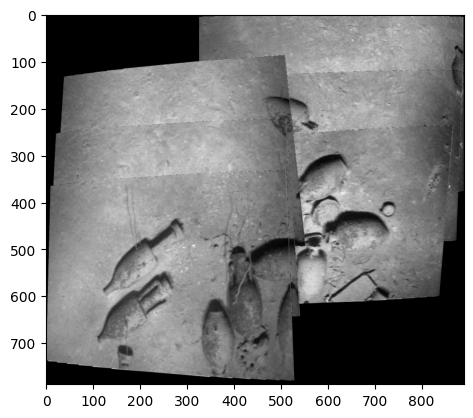

In [16]:
if __name__ == "__main__":
    Images = ReadImage("C:/Users/ROHIT/Downloads/6Images/6Images/img")
    
    BaseImage, _, _ = ProjectOntoCylinder(Images[0])
    for i in range(1, len(Images)):
        print('fg')
        StitchedImage = StitchImages(BaseImage, Images[i])

        BaseImage = StitchedImage.copy()    
    print("here")
    cv2.imwrite("Stitched_Panorama123.png", BaseImage)
    plt.figure()
    plt.imshow(BaseImage)

hello
fg
hello
fg
hello
fg
hello
fg
hello
fg
hello
here


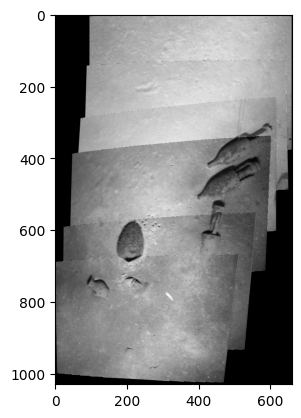

In [2]:
if __name__ == "__main__":
    Images = ReadImage("C:/Users/ROHIT/Downloads/skerkiD_subset_data/first column")
    
    BaseImage, _, _ = ProjectOntoCylinder(Images[0])
    for i in range(1, len(Images)):
        print('fg')
        StitchedImage = StitchImages(BaseImage, Images[i])

        BaseImage = StitchedImage.copy()    
    print("here")
    cv2.imwrite("Stitched_Panorama.png", BaseImage)
    plt.figure()
    plt.imshow(BaseImage)

hello
fg
hello
fg
hello
fg
hello
fg
hello
fg
hello
fg
hello
fg
hello
here


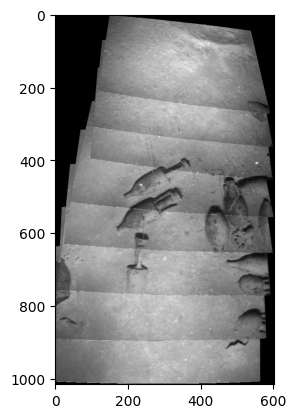

In [3]:
if __name__ == "__main__":
    Images = ReadImage("C:/Users/ROHIT/Downloads/skerkiD_subset_data/second column")
    
    BaseImage, _, _ = ProjectOntoCylinder(Images[0])
    for i in range(1, len(Images)):
        print('fg')
        StitchedImage = StitchImages(BaseImage, Images[i])

        BaseImage = StitchedImage.copy()    
    print("here")
    cv2.imwrite("Stitched_Panorama.png", BaseImage)
    plt.figure()
    plt.imshow(BaseImage)

hello
fg
hello
fg
hello
fg
hello
fg
hello
fg
hello
fg
hello
here


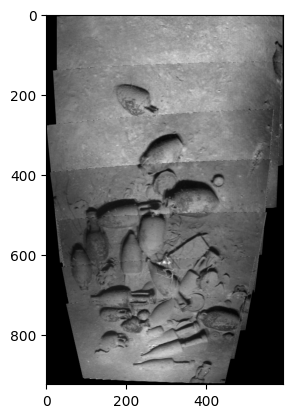

In [5]:
if __name__ == "__main__":
    Images = ReadImage("C:/Users/ROHIT/Downloads/skerkiD_subset_data/third_column")
    
    BaseImage, _, _ = ProjectOntoCylinder(Images[0])
    for i in range(1, len(Images)):
        print('fg')
        StitchedImage = StitchImages(BaseImage, Images[i])

        BaseImage = StitchedImage.copy()    
    print("here")
    cv2.imwrite("Stitched_Panorama.png", BaseImage)
    plt.figure()
    plt.imshow(BaseImage)

hello
fg
hello
fg
hello
fg
hello
fg
hello
fg
hello
fg
hello
fg
hello
here


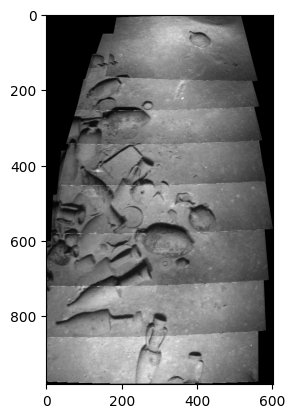

In [6]:
if __name__ == "__main__":
    Images = ReadImage("C:/Users/ROHIT/Downloads/skerkiD_subset_data/fourth column")
    
    BaseImage, _, _ = ProjectOntoCylinder(Images[0])
    for i in range(1, len(Images)):
        print('fg')
        StitchedImage = StitchImages(BaseImage, Images[i])

        BaseImage = StitchedImage.copy()    
    print("here")
    cv2.imwrite("Stitched_Panorama.png", BaseImage)
    plt.figure()
    plt.imshow(BaseImage)

hello
fg
hello
fg
hello
fg
hello
fg
hello
fg
hello
fg
hello
fg
hello
fg
hello
fg
hello
fg
hello
fg
hello
fg
hello
fg
hello
here


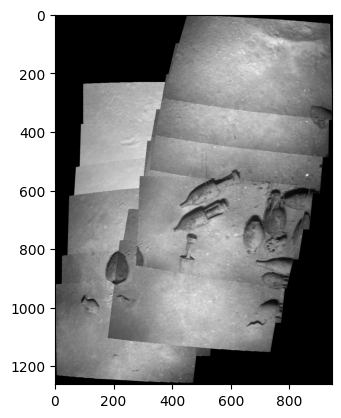

In [8]:
if __name__ == "__main__":
    Images = ReadImage("C:/Users/ROHIT/Downloads/skerkiD_subset_data/all")
    
    BaseImage, _, _ = ProjectOntoCylinder(Images[0])
    for i in range(1, len(Images)):
        print('fg')
        StitchedImage = StitchImages(BaseImage, Images[i])

        BaseImage = StitchedImage.copy()    
    print("here")
    # cv2.imwrite("Stitched_Panorama.png", BaseImage)
    plt.figure()
    plt.imshow(BaseImage)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 

C:\Users\ROHIT\AppData\Local\Temp\ipykernel_5188\1040928969.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


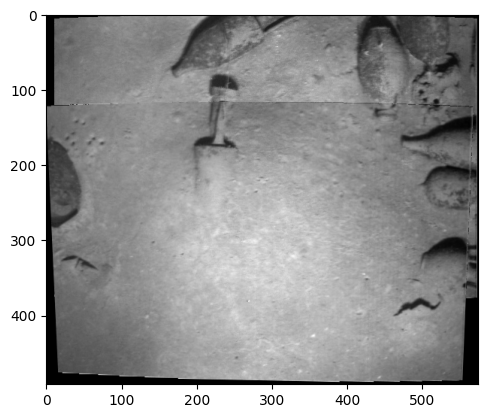

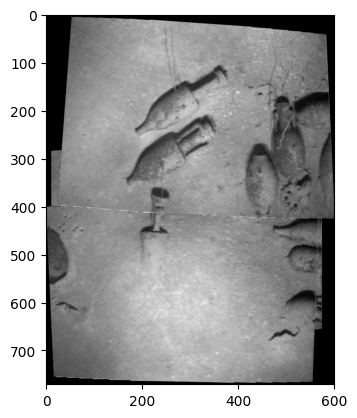

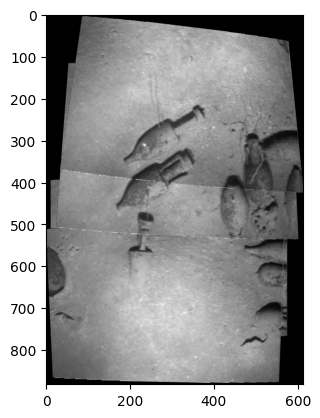

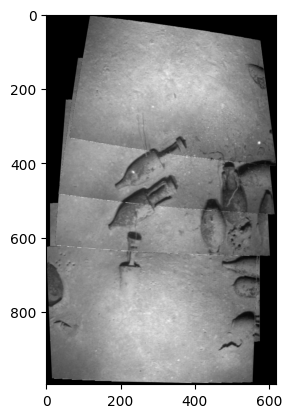

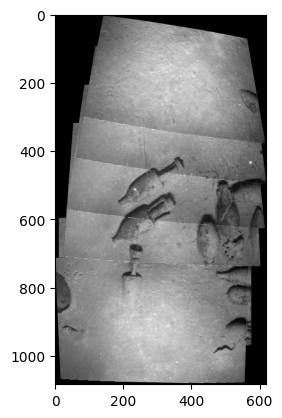

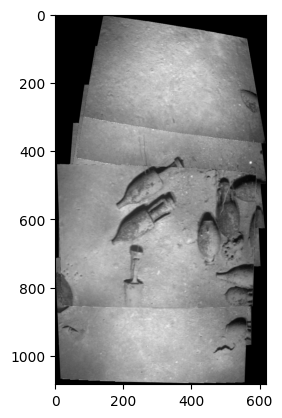

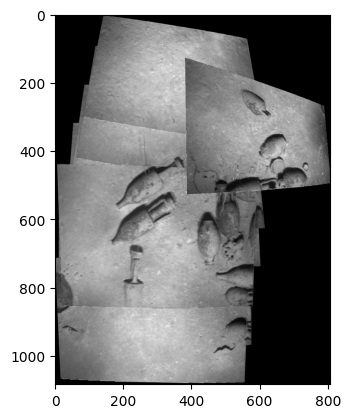

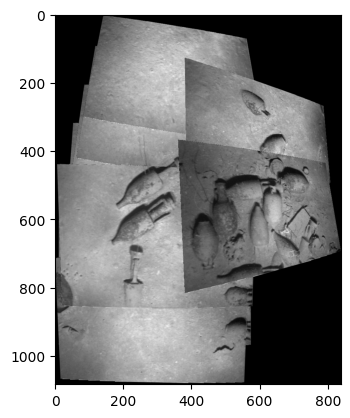

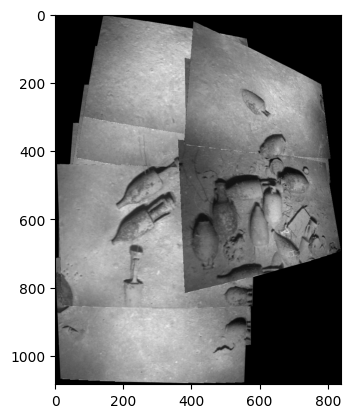

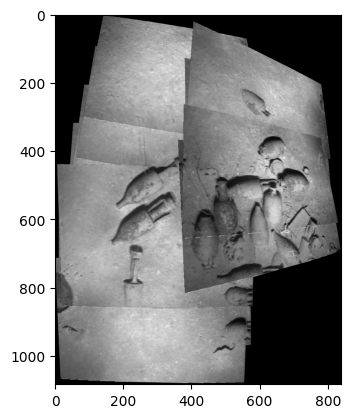

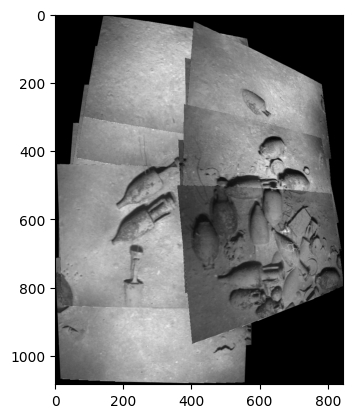

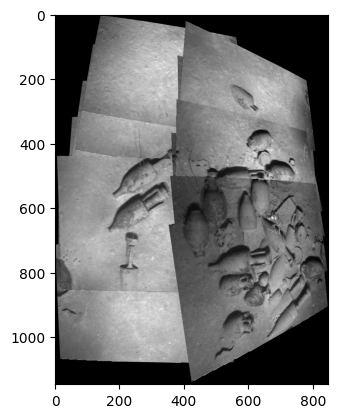

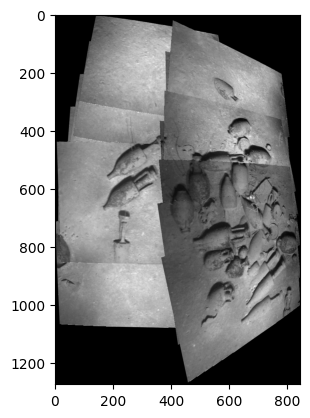

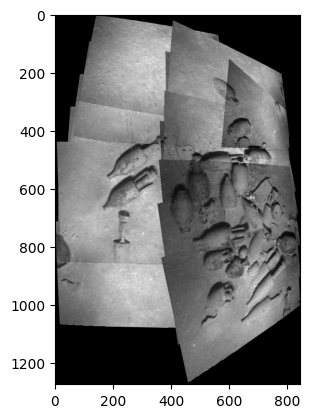

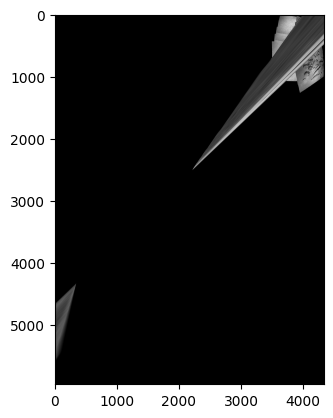

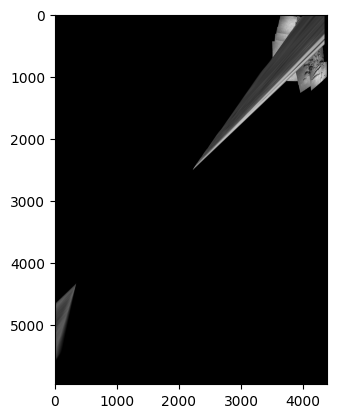

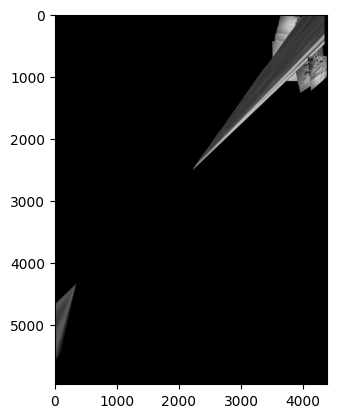

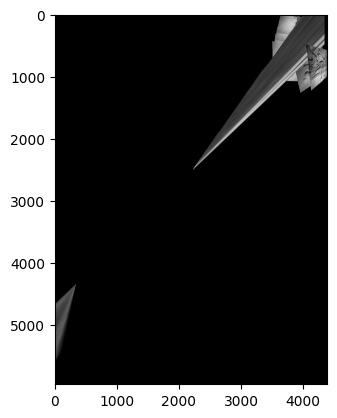

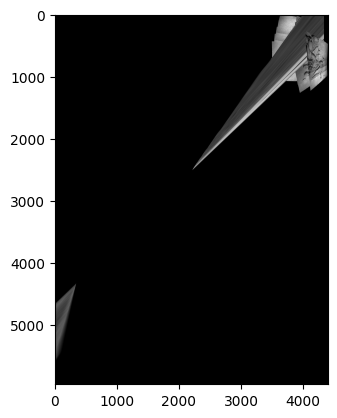

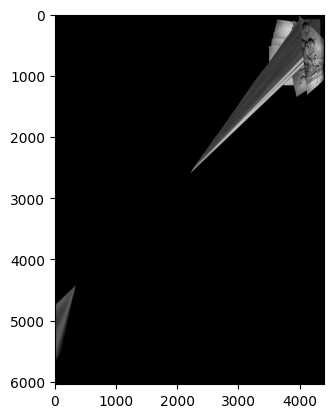

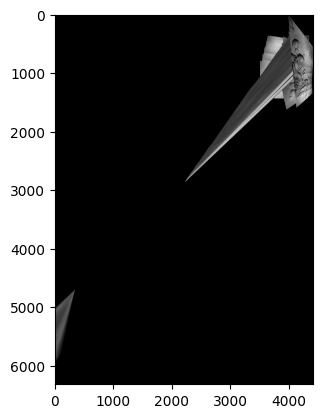

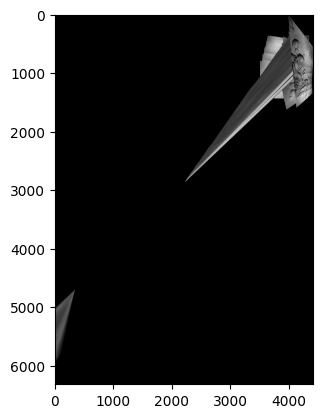

In [18]:
if __name__ == "__main__":
    Images = ReadImage("C:/Users/ROHIT/Downloads/skerkiD_subset_data/all")
    
    BaseImage, _, _ = ProjectOntoCylinder(Images[0])
    for i in range(1, len(Images)):
        # print('fg')
        print(i, end=" ")
        StitchedImage = StitchImages(BaseImage, Images[i])

        BaseImage = StitchedImage.copy()    
        if True:
            plt.figure()
            plt.imshow(BaseImage)
    # print("here")
    # cv2.imwrite("Stitched_Panorama.png", BaseImage)
    plt.figure()
    plt.imshow(BaseImage)